In [2]:
# Importing Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys, time, datetime, json, random
import seaborn as sns
import pandas as pd
from collections import namedtuple


In [3]:
# Function to plot stats
def plot_navigation_stats(stats, smoothing_window=10, noshow=False):
    # Plot the navigation steps over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Steps Taken")
    plt.title("Steps Taken by Robot Over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode rewards over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Reward (Smoothed)")
    plt.title("Robot Reward over Time (Smoothed)")
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)


In [4]:
# Define the factory grid dimensions
factory_rows = 10
factory_cols = 10

# Define actions the robot can take
actions = ['up', 'right', 'down', 'left']  # Actions to move in different directions


[-100.   -1. -100. -100. -100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
[-100.   -1. -100. -100. -100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
[-100.   -1. -100. -100. -100. -100. -100. -100. -100. -100.]
[-100.   -1. -100. -100. -100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
[-100.   -1. -100. -100. -100. -100.   -1. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.]
[-100.   -1. -100. -100. -100. -100. -100. -100. -100. -100.]


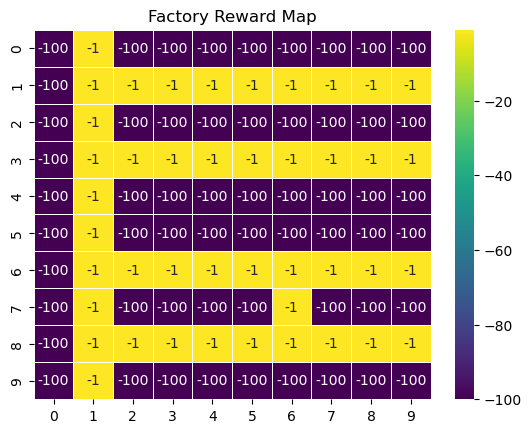

In [5]:
# Rewards table for each state in the factory
reward_table = np.full((factory_rows, factory_cols), -100.)  # Default negative rewards (penalty)

# Define corridors (pathways for the robot to move)
paths = {}
paths[0] = [1, 10]
paths[1] = [i for i in range(1, 11)]
paths[2] = [1, 10,11]
paths[3] = [i for i in range(1, 11)]
paths[4] = [1, 10]
paths[5] = [1,10]
paths[6] = [i for i in range(1, 11)]
paths[7] = [1,6,10]
paths[8] = [i for i in range(1,11)]
paths[9] = [1, 10]

# Assign rewards to the valid paths (corridors)
for row_index in range(factory_rows):
    if row_index in paths:
        for col_index in paths[row_index]:
            if col_index < factory_cols:
                reward_table[row_index, col_index] = -1.  # Movement along paths (corridors)

# Output the reward matrix
for each_row in reward_table:
    print(each_row)

r = np.array(reward_table)

# Display heatmap of rewards
sns.heatmap(r, cmap='viridis', annot=True, fmt=".0f", linewidths=0.5)
plt.title('Factory Reward Map')
plt.show()


In [6]:
# Implementing Q-Learning Algorithm for robot pathfinding
epsilon = 1  # Exploration-exploitation parameter
gamma = 0.9  # Discount factor
alpha = 0.9  # Learning rate

# Variables to track values for plotting
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

# Function to get shortest route for the robot to travel from start to goal
def find_route(start_row, start_col, end_row, end_col):
    """
    Returns the shortest route from start to goal within the factory floor.
    """
    r_new = np.copy(r)
    r_new[end_row, end_col] = 100.  # Reward at the goal
    r_new[start_row, start_col] = -1.  # Reward for the start location

    # Initialize Q-values for each state-action pair
    Q = np.zeros((factory_rows, factory_cols, 4))

    def is_terminal_state(row, col):
        if r_new[row, col] == -1:
            return False  # Not a terminal state (can move)
        return True  # Terminal state (goal reached)

    def get_start_location():
        row = np.random.randint(factory_rows)
        col = np.random.randint(factory_cols)
        while is_terminal_state(row, col):
            row = np.random.randint(factory_rows)
            col = np.random.randint(factory_cols)
        return row, col

    def get_next_action(row, col, epsilon):
        if np.random.random() < epsilon:
            return np.argmax(Q[row, col])  # Exploiting the best action
        else:
            return np.random.randint(4)  # Random action (exploration)

    def get_next_location(row, col, action_index):
        new_row, new_col = row, col
        if actions[action_index] == 'up' and row > 0:
            new_row -= 1
        elif actions[action_index] == 'down' and row < factory_rows - 1:
            new_row += 1
        elif actions[action_index] == 'right' and col < factory_cols - 1:
            new_col += 1
        elif actions[action_index] == 'left' and col > 0:
            new_col -= 1
        return new_row, new_col

    # Training the robot over multiple episodes
    episodes = 300
    stats = EpisodeStats(episode_lengths=np.zeros(episodes), episode_rewards=np.zeros(episodes))

    for episode in range(episodes):
        episode_reward = 0
        row, col = get_start_location()
        t = 0
        while not is_terminal_state(row, col):
            t += 1
            action_index = get_next_action(row, col, epsilon)
            old_row, old_col = row, col
            row, col = get_next_location(row, col, action_index)
            reward = r_new[row, col]
            episode_reward += reward
            stats.episode_rewards[episode] += reward
            stats.episode_lengths[episode] = t
            old_Q = Q[old_row, old_col, action_index]
            TD = reward + (gamma * np.max(Q[row, col])) - old_Q
            new_Q = old_Q + (alpha * TD)
            Q[old_row, old_col, action_index] = new_Q

    print("Training Complete")

    # Trace the shortest path after training
    if is_terminal_state(start_row, start_col):
        return []
    else:
        current_row, current_col = start_row, start_col
        path = [[current_row, current_col]]
        while not is_terminal_state(current_row, current_col):
            action_index = get_next_action(current_row, current_col, 1.0)
            current_row, current_col = get_next_location(current_row, current_col, action_index)
            path.append([current_row, current_col])

        print(f"Shortest route from {[start_row, start_col]} to {[end_row, end_col]} is:")
        return path, stats


Training Complete
Shortest route from [1, 9] to [8, 9] is:
[[1, 9], [1, 8], [1, 7], [1, 6], [1, 5], [1, 4], [1, 3], [1, 2], [1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8], [8, 9]]


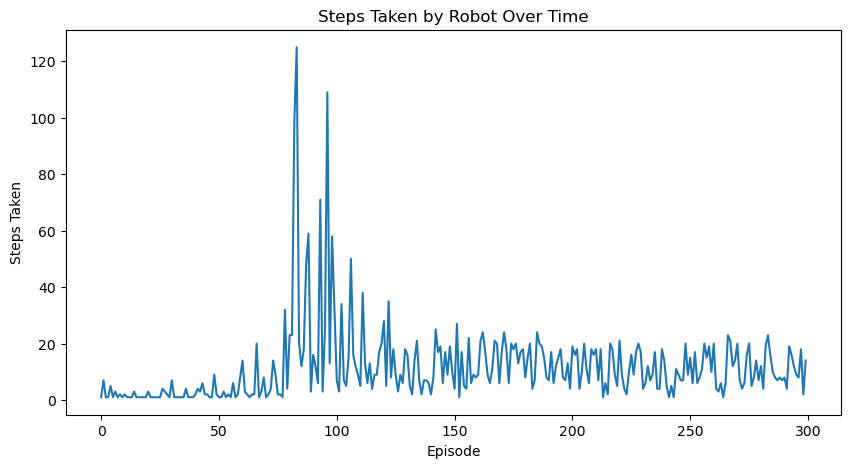

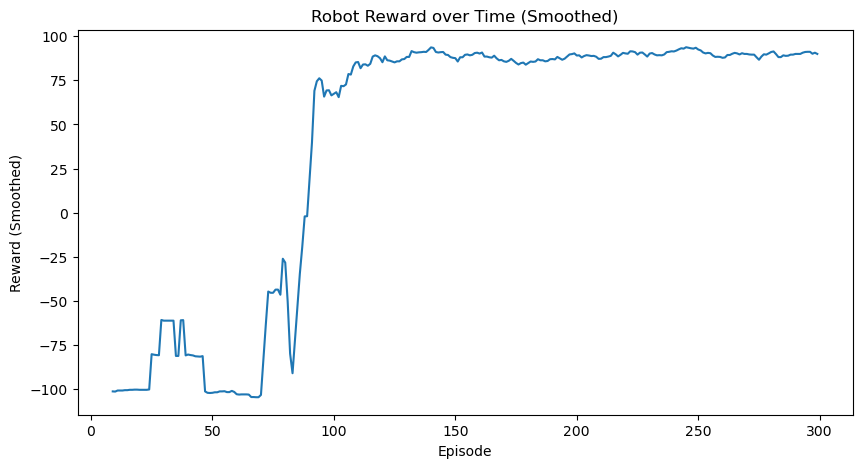

In [7]:
# Test the pathfinding function
shortest_path, stats = find_route(1, 9, 8, 9)
print(shortest_path)
plot_navigation_stats(stats)


In [8]:
# Function for robot to return home after task
def return_to_station(start_row, start_col, end_row, end_col, home_row=1, home_col=9):
    return find_route(start_row, start_col, end_row, end_col) + find_route(end_row, end_col, home_row, home_col)


Training Complete
Shortest route from [1, 8] to [7, 6] is:
Training Complete
Shortest route from [7, 6] to [1, 9] is:
[[1, 8], [1, 7], [1, 6], [1, 5], [1, 4], [1, 3], [1, 2], [1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [6, 2], [6, 3], [6, 4], [6, 5], [6, 6], [7, 6]] [[7, 6], [6, 6], [6, 5], [6, 4], [6, 3], [6, 2], [6, 1], [5, 1], [4, 1], [3, 1], [2, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9]]


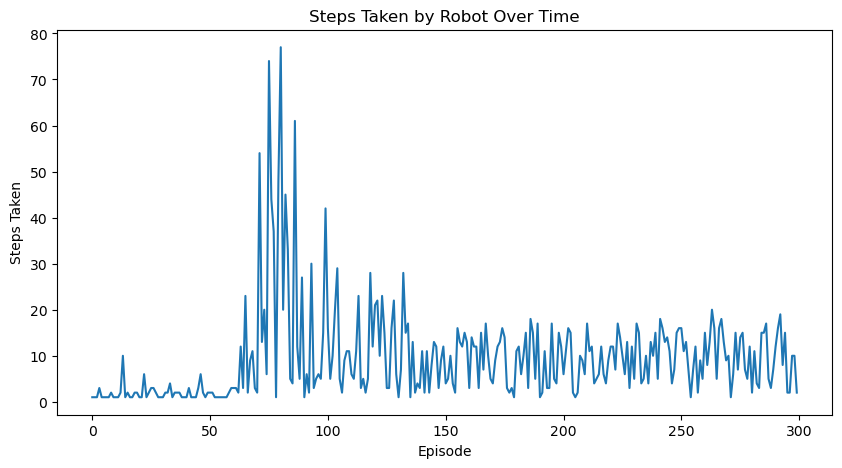

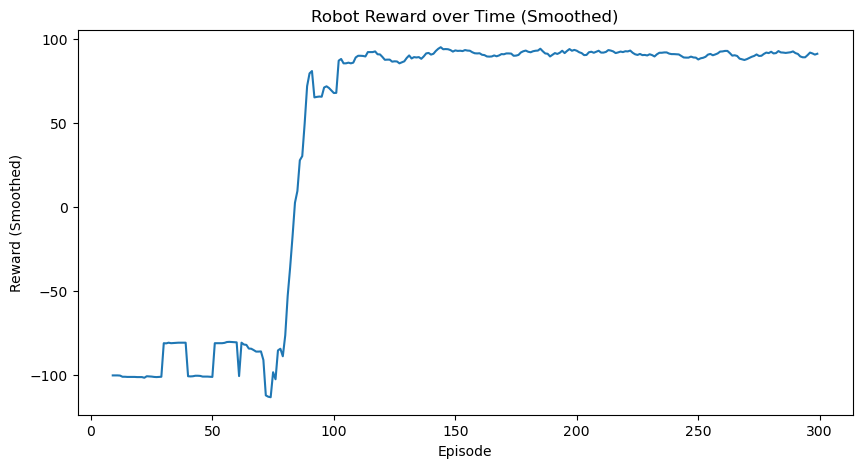

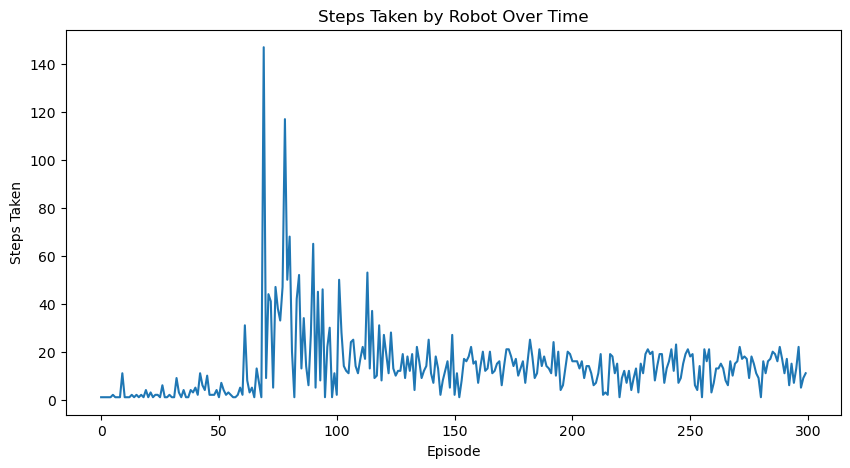

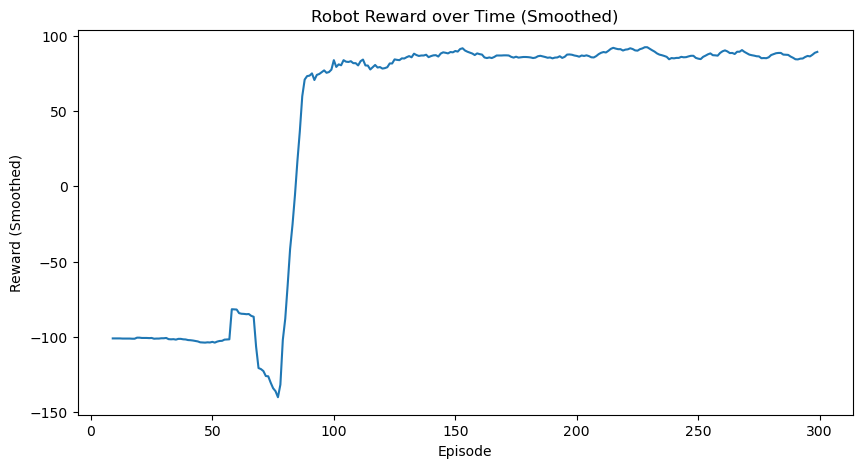

In [9]:
# Test the return-to-station function
shortest_path_to, stats_to, shortest_path_from, stats_from = return_to_station(1, 8, 7, 6)
print(shortest_path_to, shortest_path_from)

# Plot stats for both routes
plot_navigation_stats(stats_to)
plot_navigation_stats(stats_from)
